# Classification

### Import Libraries

In [122]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import load_model

### Import Labeled Polygons and Orthophoto

#### import polygons into gdf

In [123]:
import geopandas as gpd

# Replace with your shapefile path (it can be the .shp or just the folder path if all files are together)
shapefile_path = "Labeled_Data/labeled_polygons.shp"

# Read the shapefile
gdf = gpd.read_file(shapefile_path)

# Display the first few rows to check
gdf.head()


treeID  type                                           geometry
0      18   NaN  POLYGON ((344937.199 5756979.15, 344937.37 575...
1      19   1.0  POLYGON ((344940.626 5756980.521, 344940.969 5...
2      22   1.0  POLYGON ((344934.971 5756978.121, 344935.485 5...
3      26   1.0  POLYGON ((344947.481 5756979.321, 344948.167 5...
4      27   NaN  POLYGON ((344948.338 5756978.464, 344948.509 5...

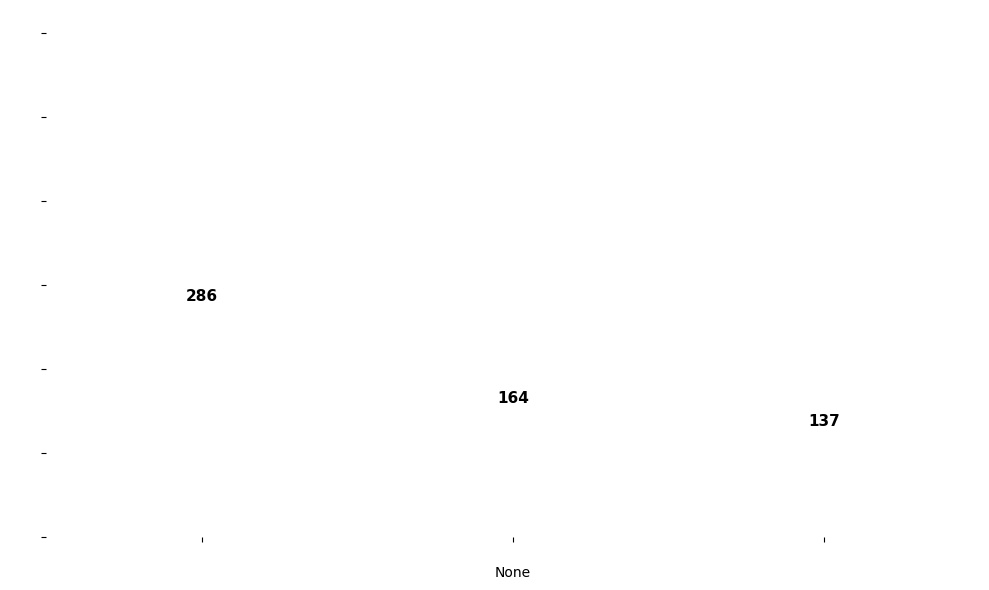

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Count the number of polygons per label, including NaNs
label_counts = gdf['type'].value_counts(dropna=False)

# Map labels
label_map = {
    1.0: 'Deciduous (1)',
    0.0: 'Coniferous (0)',
    np.nan: 'Unlabeled'
}

# Replace index with mapped labels
new_index = [label_map.get(val, str(val)) if not pd.isna(val) else 'Unlabeled' for val in label_counts.index]
label_counts.index = new_index

# Create a bar plot with custom styling
plt.figure(figsize=(10, 6), facecolor='none')  # Transparent background
ax = sns.barplot(x=label_counts.index, y=label_counts.values, color='white')  # White bars

# Add dotted grid lines for y-axis
plt.grid(axis='y', linestyle=':', linewidth=0.7, color='white')

# Add count labels inside the bars in black
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height * 0.5,  # place label halfway up the bar
        f'{int(height)}',
        ha='center',
        va='center',
        color='black',
        fontsize=11,
        fontweight='bold'
    )

# Customize plot appearance
plt.title('Number of Polygons per Label', color='white')
plt.xticks(rotation=0, color='white')
plt.yticks(color='white')
plt.gca().set_facecolor('none')  # Transparent plot area
plt.gca().spines[:].set_visible(False)  # Remove frame

plt.tight_layout()
plt.show()


#### split gdf in two: labeled and unlabeled

In [125]:
# Labeled data: where 'type' is 0 or 1
gdf_labeled = gdf[gdf['type'].isin([0, 1])]

# Unlabeled data: where 'type' is missing (NaN)
gdf_unlabeled = gdf[gdf['type'].isna()]


In [126]:
gdf_labeled

treeID  type                                           geometry
1        19   1.0  POLYGON ((344940.626 5756980.521, 344940.969 5...
2        22   1.0  POLYGON ((344934.971 5756978.121, 344935.485 5...
3        26   1.0  POLYGON ((344947.481 5756979.321, 344948.167 5...
5        30   1.0  POLYGON ((344950.737 5756975.722, 344950.909 5...
6        32   0.0  POLYGON ((344928.287 5756974.351, 344928.63 57...
..      ...   ...                                                ...
575     771   1.0  POLYGON ((344932.058 5756835.883, 344932.914 5...
576     773   1.0  POLYGON ((344957.078 5756835.369, 344957.592 5...
578     780   1.0  POLYGON ((344937.199 5756832.113, 344937.542 5...
581     786   1.0  POLYGON ((344933.6 5756829.371, 344933.771 575...
585     793   1.0  POLYGON ((344951.765 5756825.6, 344952.794 575...

[301 rows x 3 columns]

In [127]:
gdf_unlabeled

treeID  type                                           geometry
0        18   NaN  POLYGON ((344937.199 5756979.15, 344937.37 575...
4        27   NaN  POLYGON ((344948.338 5756978.464, 344948.509 5...
11       43   NaN  POLYGON ((344945.939 5756972.466, 344946.453 5...
12       45   NaN  POLYGON ((344942.169 5756973.837, 344942.34 57...
13       46   NaN  POLYGON ((344949.709 5756971.952, 344950.223 5...
..      ...   ...                                                ...
580     784   NaN  POLYGON ((344928.973 5756831.77, 344929.487 57...
582     788   NaN  POLYGON ((344947.31 5756828.685, 344947.481 57...
583     789   NaN  POLYGON ((344937.027 5756828, 344937.37 575682...
584     790   NaN  POLYGON ((344943.025 5756829.371, 344943.368 5...
586     797   NaN  POLYGON ((344946.796 5756825.429, 344947.31 57...

[286 rows x 3 columns]

In [128]:
print("Labeled:", len(gdf_labeled))
print("Unlabeled:", len(gdf_unlabeled))


Labeled: 301
Unlabeled: 286


### Prepare Images

- import labeled polygons
- Split Images with Labeled Polygons
- create 4 copies with random rotations
- create 160px x 160px image with padding for each image
- safe in separate folders -> coniferous / decidious
- safe imageFileName/polygonID in dataframe

#### make sure folders are empty

#### prepare images

In [129]:
from PIL import Image
import random
import os
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import numpy as np

image_size = 160
number_of_copies = 9 # specify this

# === Empty folders ===
for label in ["deciduous", "coniferous"]:
    folder = f"Labeled_Data/{label}"
    if os.path.exists(folder):
        for f in os.listdir(folder):
            file_path = os.path.join(folder, f)
            if os.path.isfile(file_path):
                os.remove(file_path)

# === Normalize to uint8 ===
def normalize_to_uint8(img):
    img_normalized = np.zeros_like(img, dtype=np.uint8)
    for b in range(img.shape[2]):
        band = img[:, :, b]
        p1, p99 = np.percentile(band, (1, 99))
        if p99 - p1 == 0:
            img_normalized[:, :, b] = 0
        else:
            img_normalized[:, :, b] = np.clip((band - p1) / (p99 - p1) * 255, 0, 255)
    return img_normalized

# === Center image in black 160x160 canvas ===
def center_crop_160(img):
    if not isinstance(img, Image.Image):
        img = Image.fromarray(img)
    w, h = img.size
    scale = min(image_size / w, image_size / h)
    img = img.resize((int(w * scale), int(h * scale)), Image.LANCZOS)

    bg = Image.new("RGB", (image_size, image_size), (0, 0, 0))
    upper_left = ((image_size - img.size[0]) // 2, (image_size - img.size[1]) // 2)
    bg.paste(img, upper_left)
    return bg

# === Process polygons ===
with rasterio.open("orthophoto.tif") as src:
    for idx, row in gdf_labeled.iterrows():
        try:
            out_image, _ = mask(src, [row.geometry], crop=True)
        except ValueError:
            continue

        img_array = out_image.transpose(1, 2, 0)
        if img_array.shape[2] < 3:
            continue

        rgb_array = img_array[:, :, :3]
        rgb_array = normalize_to_uint8(rgb_array)
        original_img = Image.fromarray(rgb_array)

        # Store the original + 4 random augmentations
        all_versions = [original_img]

        for _ in range(number_of_copies):
            angle = random.uniform(-360, 360)     # random rotation up to ±30 degrees
            scale = random.uniform(0.85, 1.15)   # slight random scale

            # Always apply to the original image (not the previous one)
            w, h = original_img.size
            scaled = original_img.resize((int(w * scale), int(h * scale)), Image.LANCZOS)
            rotated = scaled.rotate(angle, expand=True, fillcolor=(0, 0, 0))
            all_versions.append(rotated)

        label = "deciduous" if row["type"] == 1 else "coniferous"
        for i, variant in enumerate(all_versions):
            output_img = center_crop_160(variant)
            output_img.save(f"Labeled_Data/{label}/tree_{idx}_{i}.png")

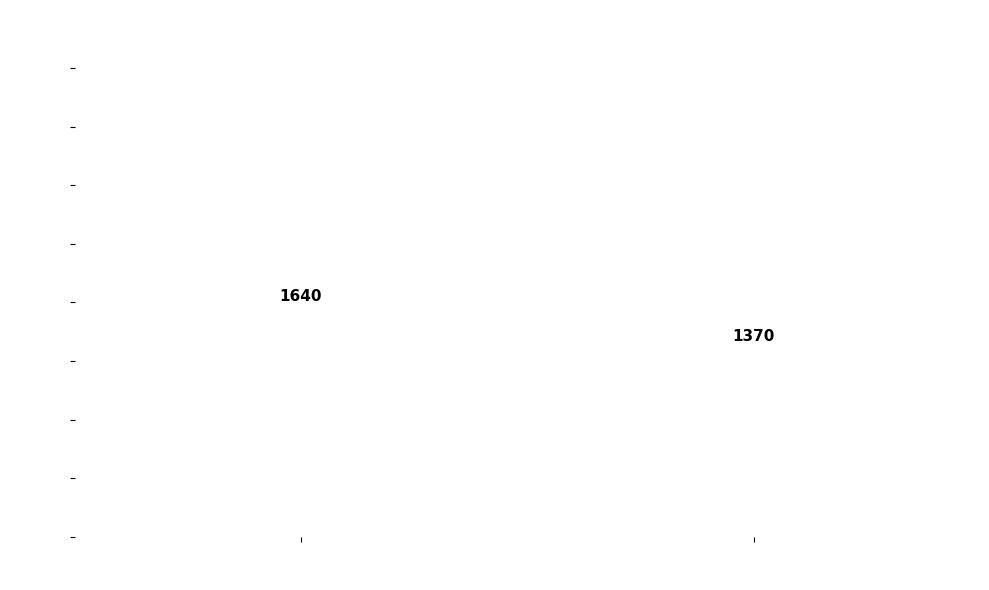

In [130]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# === Count files in each label folder ===
labels = ["deciduous", "coniferous"]
file_counts = []

for label in labels:
    folder = f"Labeled_Data/{label}"
    count = len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])
    file_counts.append(count)

# === Create bar plot with custom styling ===
plt.figure(figsize=(10, 6), facecolor='none')  # Transparent background
ax = sns.barplot(x=labels, y=file_counts, color='white')  # White bars

# Add dotted white grid lines on y-axis
plt.grid(axis='y', linestyle=':', linewidth=0.7, color='white')

# Add count labels inside the bars in black
for bar, count in zip(ax.patches, file_counts):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height * 0.5,
        f'{int(count)}',
        ha='center',
        va='center',
        color='black',
        fontsize=11,
        fontweight='bold'
    )

# Customize appearance
plt.title("Number of Files per Folder", color='white')
plt.xlabel("Label", color='white')
plt.ylabel("File Count", color='white')
plt.xticks(color='white')
plt.yticks(color='white')
ax.set_facecolor('none')  # Transparent inside plot
ax.spines[:].set_visible(False)  # Hide border

plt.tight_layout()
plt.show()


### Training

#### Data Extraction

In [131]:

dataset_path = "Labeled_Data"

### Creating TensorFlow Data Oject & Visualizing the Dataset



### Train-Test Split


In [132]:


batch_size = 32
dataset_path = "Labeled_Data"  # or your actual path

# Load training and validation datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    shuffle=True,
    image_size=(160, 160),  # match your saved image size
    batch_size=batch_size
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    shuffle=True,
    image_size=(160, 160),
    batch_size=batch_size
)

class_names = train_dataset.class_names
print("Class names:", class_names)


# Print class names
print("Class names:", train_dataset.class_names)


Found 3010 files belonging to 2 classes.
Using 2408 files for training.
Found 3010 files belonging to 2 classes.
Using 602 files for validation.
Class names: ['coniferous', 'deciduous']
Class names: ['coniferous', 'deciduous']


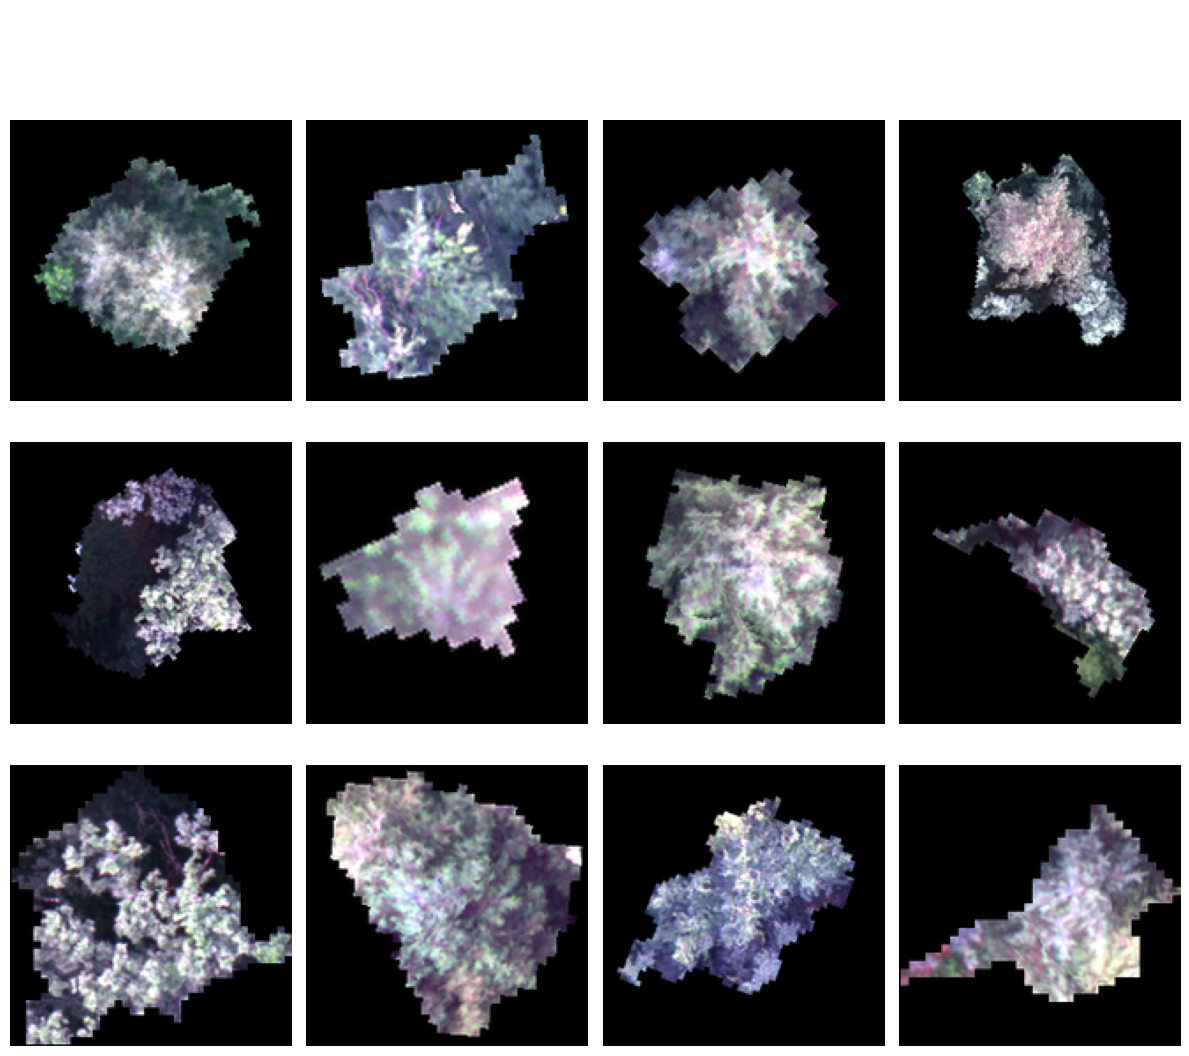

In [133]:
plt.figure(figsize=(12, 11), facecolor='none')  # Adjusted for 3 rows x 4 columns

for images, labels in train_dataset.take(1):
    num_images = min(12, images.shape[0])  # Ensure dataset has at least 12 images
    for i in range(num_images):
        ax = plt.subplot(3, 4, i + 1)  # 3 rows, 4 columns
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]], color='white', fontsize=10)
        plt.axis("off")
        ax.set_facecolor('none')

# White main title
plt.suptitle("Sample Images from Training Dataset", fontsize=16, color='white')

# Tighten layout and reserve space for the suptitle
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Preprocessing the Dataset 


#### Test & Validation Datasets

In [134]:
# # Split validation set into validation and test datasets
val_batches = tf.data.experimental.cardinality(validation_dataset)

# val_vatches object is a tensor, so we need to convert it to a number

In [135]:
int(val_batches)

19

In [136]:
# make sure at least one batch goes to test set
val_batches = tf.data.experimental.cardinality(validation_dataset).numpy()
test_split = max(1, val_batches // 5)

test_dataset = validation_dataset.take(test_split)
validation_dataset = validation_dataset.skip(test_split)


In [137]:
print('Number of validation batches:', tf.data.experimental.cardinality(validation_dataset).numpy())
print('Number of test batches:', tf.data.experimental.cardinality(test_dataset).numpy())

Number of validation batches: 16
Number of test batches: 3


#### Prefetching for optimization

In [138]:
tf.data.AUTOTUNE

-1

In [139]:
autotune = tf.data.AUTOTUNE

In [140]:
# Optimize dataset performance with prefetching
train_dataset = train_dataset.prefetch(buffer_size=autotune)
validation_dataset = validation_dataset.prefetch(buffer_size=autotune)
test_dataset = test_dataset.prefetch(buffer_size=autotune)

### Data Augmentation

In [141]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # ← flips both ways
    tf.keras.layers.RandomRotation(0.02),
])

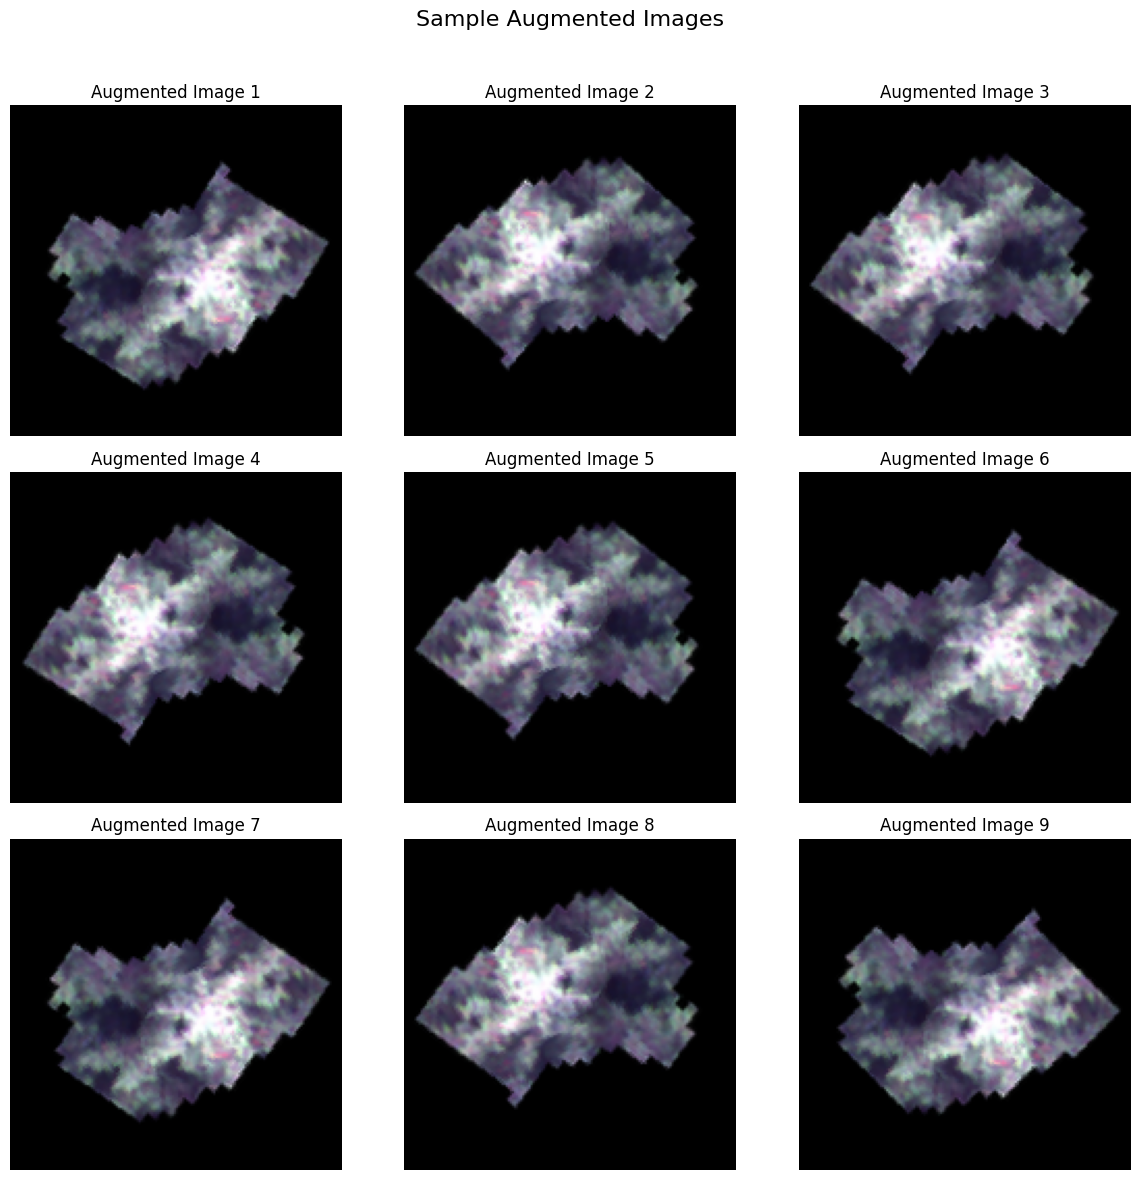

In [142]:
# Visualize augmented images
plt.figure(figsize=(12, 12))
for images, _ in train_dataset.take(1):
    sample_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(sample_image, 0))
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(f"Augmented Image {i+1}", fontsize=12)
plt.suptitle("Sample Augmented Images", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

### Transfer Learning with MobileNetV2



In [143]:
img_size = (160, 160)  # width, height

In [144]:
img_shape = img_size + (3,)

In [145]:
img_size

(160, 160)

In [146]:
img_shape

(160, 160, 3)

#### CNN Architecture

In [147]:
base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape, 
                                               include_top=False, # Exclude the ImageNet classifier at the top
                                               weights='imagenet') # Use the pre-trained weights from ImageNet

In [148]:
base_model.trainable = False # Freeze the base model to keep the pre-trained weights

#### MobileNetV2 Structure

In [149]:
inputs = tf.keras.Input(shape=img_shape)
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)

#### Last Layers

In [150]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D() # layer object

# Apply the layer to MobileNetV2
x = global_average_layer(x)
# x = tf.keras.layers.Dropout(0.2)(x) ### Optional: Add a dropout layer

prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid') # layer object

#add a droupout layer to reduce overfitting
x = tf.keras.layers.Dropout(0.05)(x) # Optional: Add a dropout layer

# Apply Fully Connected Layer to predict the class
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [151]:
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_2 (TrueDivide)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_2 (Subtract)           │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

#### Training the Model


In [152]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.1,
    decay_steps=batch_size, # Learning rate will decrease every batch
    decay_rate=0.8 # rate of decrease means 90% of the learning rate is decreased
)

In [153]:
# Compile the model structure for training
base_learning_rate = 0.1
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), # Adam deals with gradient descent
              loss=tf.keras.losses.BinaryCrossentropy(), # measures the difference between two probability distributions
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')]) # calculates how often predictions match binary labels

#### Early Stop, Epochs & Saving the Best Model

In [154]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [155]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True)

In [156]:
# Epochs are the number of times the model will see the entire dataset
# Start with a small number of epochs to prevent overfitting
# Epochs usually are in the range of 10 to 100. Standard is up to 50.
initial_epochs = 50

#### Training & Saving (Best Model + Metrics)

In [157]:
import json

# Train the model with callbacks
history = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset,
    callbacks=[early_stopping, model_checkpoint], # Callbacks are used to customize the training process
    verbose=1  # Verbosity level: 1 = progress bar, 2 = one line per epoch
)

# Save training history
with open('training_history.json', 'w') as file: # open creates a file
    json.dump(history.history, file) # dump saves it as a json file

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 55s 631ms/step - accuracy: 0.8416 - loss: 1.5606 - val_accuracy: 0.8933 - val_loss: 0.5549
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 32s 422ms/step - accuracy: 0.9180 - loss: 0.4687 - val_accuracy: 0.9091 - val_loss: 0.5595
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 33s 432ms/step - accuracy: 0.9406 - loss: 0.3041 - val_accuracy: 0.9308 - val_loss: 0.2588
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 33s 428ms/step - accuracy: 0.9385 - loss: 0.2734 - val_accuracy: 0.9526 - val_loss: 0.1912
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 32s 415ms/step - accuracy: 0.9662 - loss: 0.1296 - val_accuracy: 0.9447 - val_loss: 0.1996
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 32s 418ms/step - accuracy: 0.9644 - loss: 0.1196 - val_accuracy: 0.9605 - val_loss: 0.1636
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 33s 433ms/step - accuracy: 0.9661 - loss: 0.1144 - val_accuracy: 0.9585 - val_loss: 0.1358
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 31s 414ms/step - accuracy: 0.9756 - loss: 0.0938 - val_accu

In [158]:
best_model = load_model('best_model.keras')

### Fine-Tuning the Model


#### Freeze the first 100 layers

In [159]:
len(base_model.layers)

154

In [160]:
for layer in base_model.layers[:100]: # Freeze the first 100 layers
    layer.trainable = False

In [161]:
base_learning_rate
fine_tune_learning_rate = base_learning_rate / 10 # 10 times smaller learning rate for fine-tuning

In [162]:
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_learning_rate),  # Smaller learning rate
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')]
)

In [163]:
# Same callbacks
fine_tune_early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
fine_tune_best_model_checkpoint = ModelCheckpoint(filepath='fine_tuned_best_model.keras', monitor='val_loss', save_best_only=True)


# Define fine-tuning epochs
fine_tune_epochs = 50
total_epochs = initial_epochs + fine_tune_epochs

In [164]:
# Fine-tune the model
history_fine = best_model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],  # Continue from where the initial training ended
    validation_data=validation_dataset,
    callbacks=[fine_tune_early_stopping, fine_tune_best_model_checkpoint],  # Add callbacks
    verbose=1
)

# Save fine-tuning history
with open('fine_tuning_history.json', 'w') as file:
    json.dump(history_fine.history, file)

Epoch 44/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 42s 478ms/step - accuracy: 0.9603 - loss: 0.1327 - val_accuracy: 0.9466 - val_loss: 0.1714
Epoch 45/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 33s 437ms/step - accuracy: 0.9699 - loss: 0.1112 - val_accuracy: 0.9684 - val_loss: 0.0882
Epoch 46/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 32s 423ms/step - accuracy: 0.9610 - loss: 0.1382 - val_accuracy: 0.9605 - val_loss: 0.1162
Epoch 47/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 33s 433ms/step - accuracy: 0.9696 - loss: 0.1017 - val_accuracy: 0.9664 - val_loss: 0.1324
Epoch 48/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 33s 437ms/step - accuracy: 0.9654 - loss: 0.1093 - val_accuracy: 0.9407 - val_loss: 0.2106
Epoch 49/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 35s 457ms/step - accuracy: 0.9726 - loss: 0.0725 - val_accuracy: 0.9605 - val_loss: 0.1280
Epoch 50/100
76/76 ━━━━━━━━━━━━━━━━━━━━ 34s 449ms/step - accuracy: 0.9628 - loss: 0.1146 - val_accuracy: 0.9664 - val_loss: 0.0943


### Evaluating and Visualizing Results

In [165]:
# Using the best model
model = tf.keras.models.load_model('fine_tuned_best_model.keras')

In [166]:
# Evaluate the fine-tuned model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 317ms/step - accuracy: 0.9518 - loss: 0.1373


In [167]:
# Load training history
with open('training_history.json', 'r') as file:
    training_history = json.load(file)

# Load fine-tuning history
with open('fine_tuning_history.json', 'r') as file:
    fine_tuning_history = json.load(file)

In [168]:
# Combine training and fine-tuning metrics
acc = training_history['accuracy'] + fine_tuning_history['accuracy']
val_acc = training_history['val_accuracy'] + fine_tuning_history['val_accuracy']

loss = training_history['loss'] + fine_tuning_history['loss']
val_loss = training_history['val_loss'] + fine_tuning_history['val_loss']

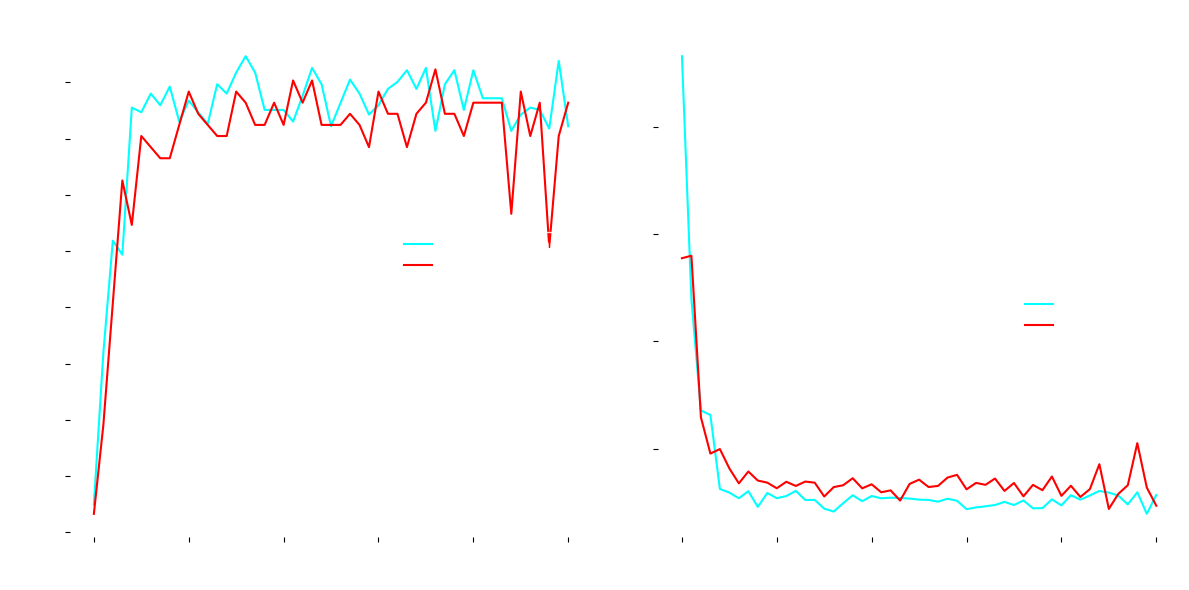

In [189]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6), facecolor='none')  # Transparent background

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy', color='cyan')  # Changed to yellow
plt.plot(val_acc, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy', color='white', fontsize=14)
plt.xlabel('Epochs', color='white')
plt.ylabel('Accuracy', color='white')
plt.grid(True, linestyle=':', linewidth=0.8, color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.legend(loc='lower right', bbox_to_anchor=(1, 0.5), facecolor='none', edgecolor='white', labelcolor='white')

# Remove borders
ax = plt.gca()
ax.set_facecolor('none')
for spine in ax.spines.values():
    spine.set_visible(False)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss', color='cyan')  # Changed to yellow
plt.plot(val_loss, label='Validation Loss', color='red')
plt.title('Training and Validation Loss', color='white', fontsize=14)
plt.xlabel('Epochs', color='white')
plt.ylabel('Loss', color='white')
plt.grid(True, linestyle=':', linewidth=0.8, color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.5), facecolor='none', edgecolor='white', labelcolor='white')

# Remove borders
ax = plt.gca()
ax.set_facecolor('none')
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()


In [170]:
# Gather ground truth and predictions from the test dataset
ground_truth = np.concatenate([labels.numpy() for _, labels in test_dataset]) 

#predictions = np.concatenate([tf.where(model(X).numpy().flatten() < 0.5, 0, 1).numpy() for X, _ in test_dataset])


In [171]:
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images).flatten()
    bin_preds = (predictions > 0.5).astype("int32")

    y_true.extend(labels.numpy())
    y_pred.extend(bin_preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


In [172]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

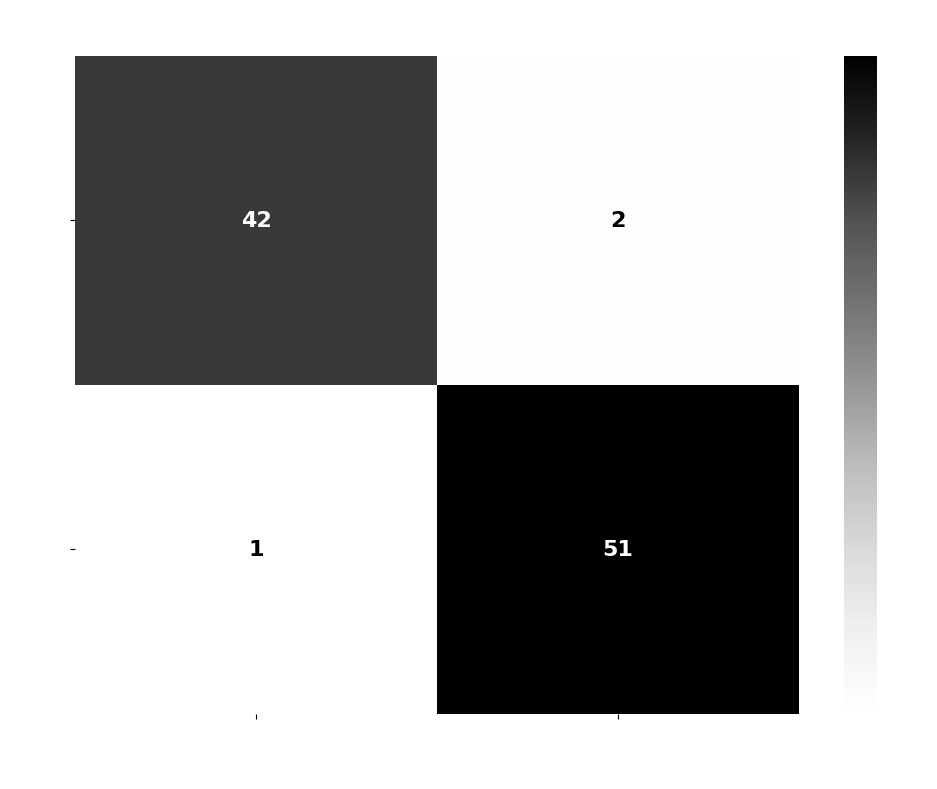

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot base heatmap without annotations
plt.figure(figsize=(10, 8), facecolor='none')
ax = sns.heatmap(
    conf_matrix,
    annot=False,  # We will add annotations manually
    fmt="d",
    cmap="Greys",
    xticklabels=class_names,
    yticklabels=class_names,
    cbar=True,
    cbar_kws={"label": "Number of Samples",}
)

# Add dynamic text annotations
max_val = conf_matrix.max()
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        val = conf_matrix[i, j]
        text_color = 'white' if val > (max_val * 0.5) else 'black'
        ax.text(
            j + 0.5, i + 0.5,
            str(val),
            ha='center',
            va='center',
            fontsize=16,
            fontweight='bold',
            color=text_color
        )

# Style plot
plt.xlabel("Predicted Label", color='white', fontsize=16, labelpad=12)
plt.ylabel("True Label", color='white', fontsize=16, labelpad=12)
plt.title("Confusion Matrix", color='white', fontsize=18, pad=20)
plt.xticks(color='white', fontsize=14)
plt.yticks(color='white', fontsize=14)

# Style colorbar
colorbar = ax.collections[0].colorbar
colorbar.ax.yaxis.label.set_color('white')
colorbar.ax.tick_params(colors='white', labelsize=12)

# Transparent and clean
ax.set_facecolor('none')
for spine in ax.spines.values():
    spine.set_visible(False)

plt.tight_layout()
plt.show()


In [174]:
len(validation_dataset)

16

In [175]:
from sklearn.metrics import classification_report

In [176]:
# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

  coniferous       0.98      0.95      0.97        44
   deciduous       0.96      0.98      0.97        52

    accuracy                           0.97        96
   macro avg       0.97      0.97      0.97        96
weighted avg       0.97      0.97      0.97        96



In [177]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

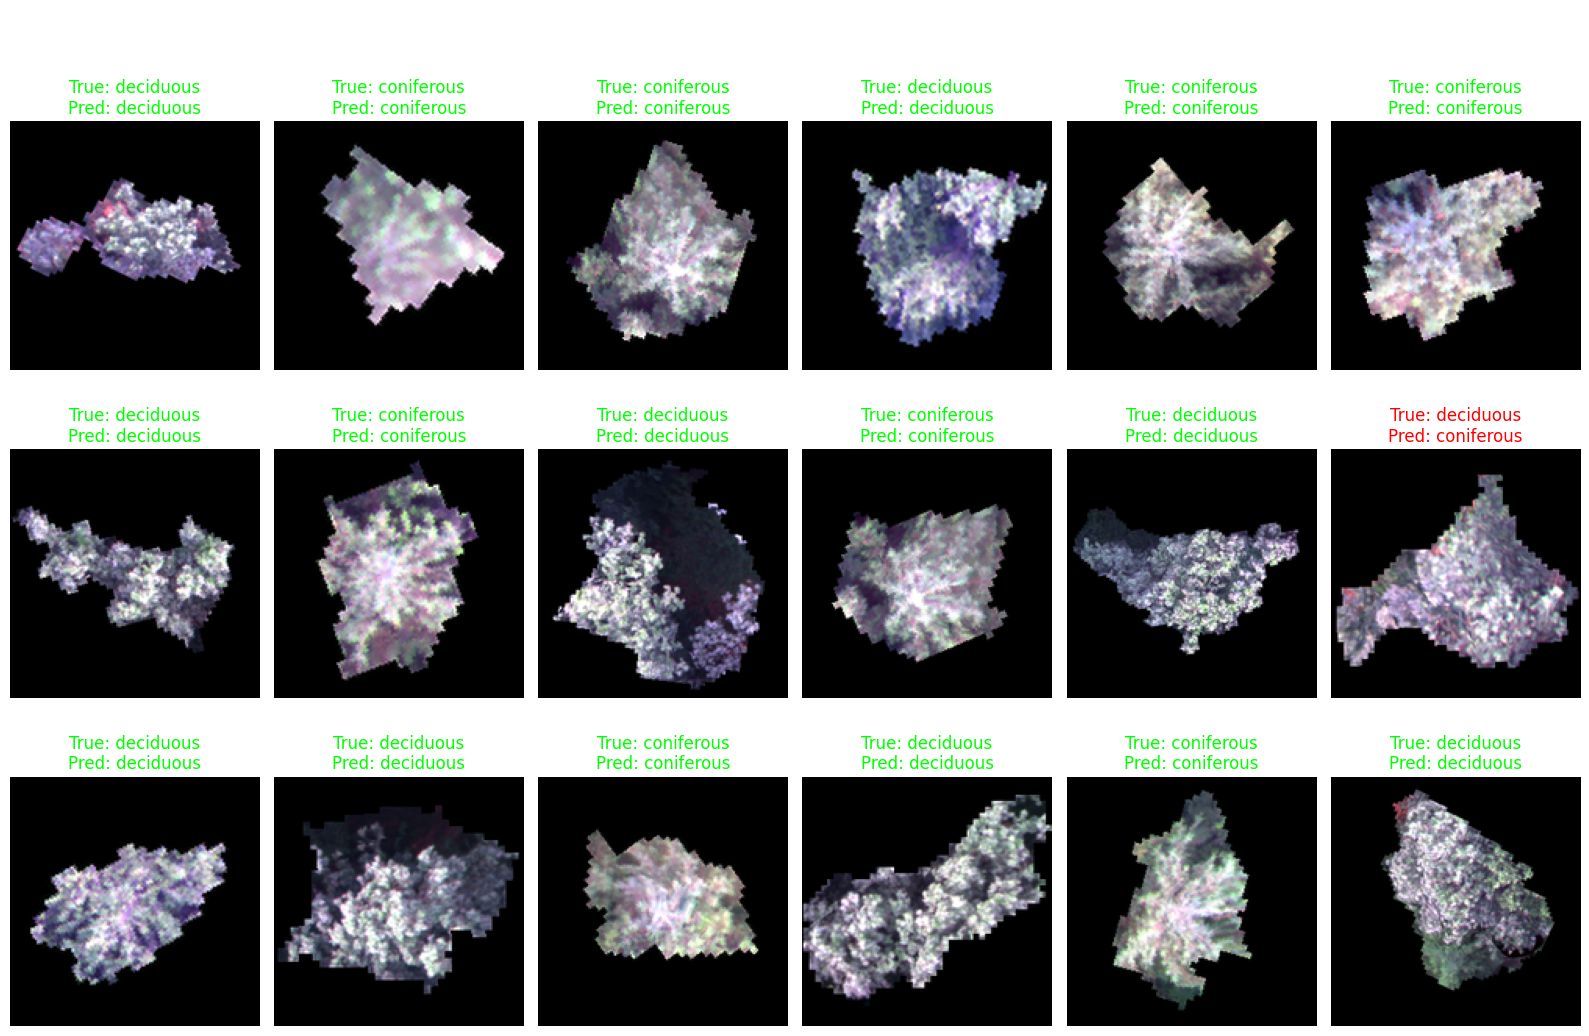

In [212]:
import matplotlib.pyplot as plt

# Get a batch of test data
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

# Generate predictions
predictions = model.predict_on_batch(image_batch).flatten()
predictions = tf.where(predictions < 0.5, 0, 1).numpy()

# Plot settings
plt.figure(figsize=(16, 11), facecolor='none')  # Transparent background

for i in range(18):
    ax = plt.subplot(3, 6, i + 1)
    ax.imshow(image_batch[i].astype("uint8"))
    ax.axis("off")

    # Title
    true_label = label_batch[i]
    pred_label = predictions[i]
    title = f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}"
    color = 'lime' if true_label == pred_label else 'red'  # Bright green for correct predictions
    ax.set_title(title, color=color, fontsize=12)

# Overall title
plt.suptitle("Predictions on Test Data", fontsize=18, fontweight='bold', color='white')
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


### Apply to unlabeled data

In [242]:
import tensorflow as tf
from PIL import Image
import numpy as np
import rasterio
from rasterio.mask import mask

# Load your trained model
#model = tf.keras.models.load_model("path/to/your_model.h5")  # or .keras if saved that way

# Helper: Normalize and resize to 160x160 with black padding
def prepare_image(img_array):
    def normalize_to_uint8(img):
        img_normalized = np.zeros_like(img, dtype=np.uint8)
        for b in range(img.shape[2]):
            band = img[:, :, b]
            p1, p99 = np.percentile(band, (1, 99))
            if p99 - p1 == 0:
                img_normalized[:, :, b] = 0
            else:
                img_normalized[:, :, b] = np.clip((band - p1) / (p99 - p1) * 255, 0, 255)
        return img_normalized

    img_array = normalize_to_uint8(img_array)

    # Resize and center on 160x160 black background
    img = Image.fromarray(img_array)
    w, h = img.size
    scale = min(160 / w, 160 / h)
    img = img.resize((int(w * scale), int(h * scale)), Image.LANCZOS)

    bg = Image.new("RGB", (160, 160), (0, 0, 0))
    upper_left = ((160 - img.size[0]) // 2, (160 - img.size[1]) // 2)
    bg.paste(img, upper_left)

    return np.array(bg)

# Store predicted labels
predicted_labels = []

with rasterio.open("orthophoto.tif") as src:
    for idx, row in gdf_unlabeled.iterrows():
        try:
            out_image, _ = mask(src, [row.geometry], crop=True)
        except ValueError:
            predicted_labels.append(None)
            continue

        img_array = out_image.transpose(1, 2, 0)

        if img_array.shape[2] < 3:
            predicted_labels.append(None)
            continue

        rgb_array = img_array[:, :, :3]
        processed_img = prepare_image(rgb_array)

        # Add batch dimension and predict
        input_tensor = tf.expand_dims(processed_img, axis=0)  # shape (1, 160, 160, 3)
        prediction = model.predict(input_tensor)
        predicted_class = int(prediction[0][0] > 0.5)

        predicted_labels.append(predicted_class)

# Add predictions to GeoDataFrame
gdf_unlabeled["predicted_type"] = predicted_labels

# Save if needed
# gdf_unlabeled.to_file("predicted_tree_crowns.shp")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━

In [243]:
label_counts = gdf_unlabeled["predicted_type"].value_counts()
print("Predicted label counts:")
print(label_counts)

# Optional: map to readable names
label_names = {0: "Coniferous", 1: "Deciduous"}
for label, count in label_counts.items():
    print(f"{label_names.get(label, 'Unknown')}: {count}")


Predicted label counts:
predicted_type
1    193
0     93
Name: count, dtype: int64
Deciduous: 193
Coniferous: 93


#### visualize

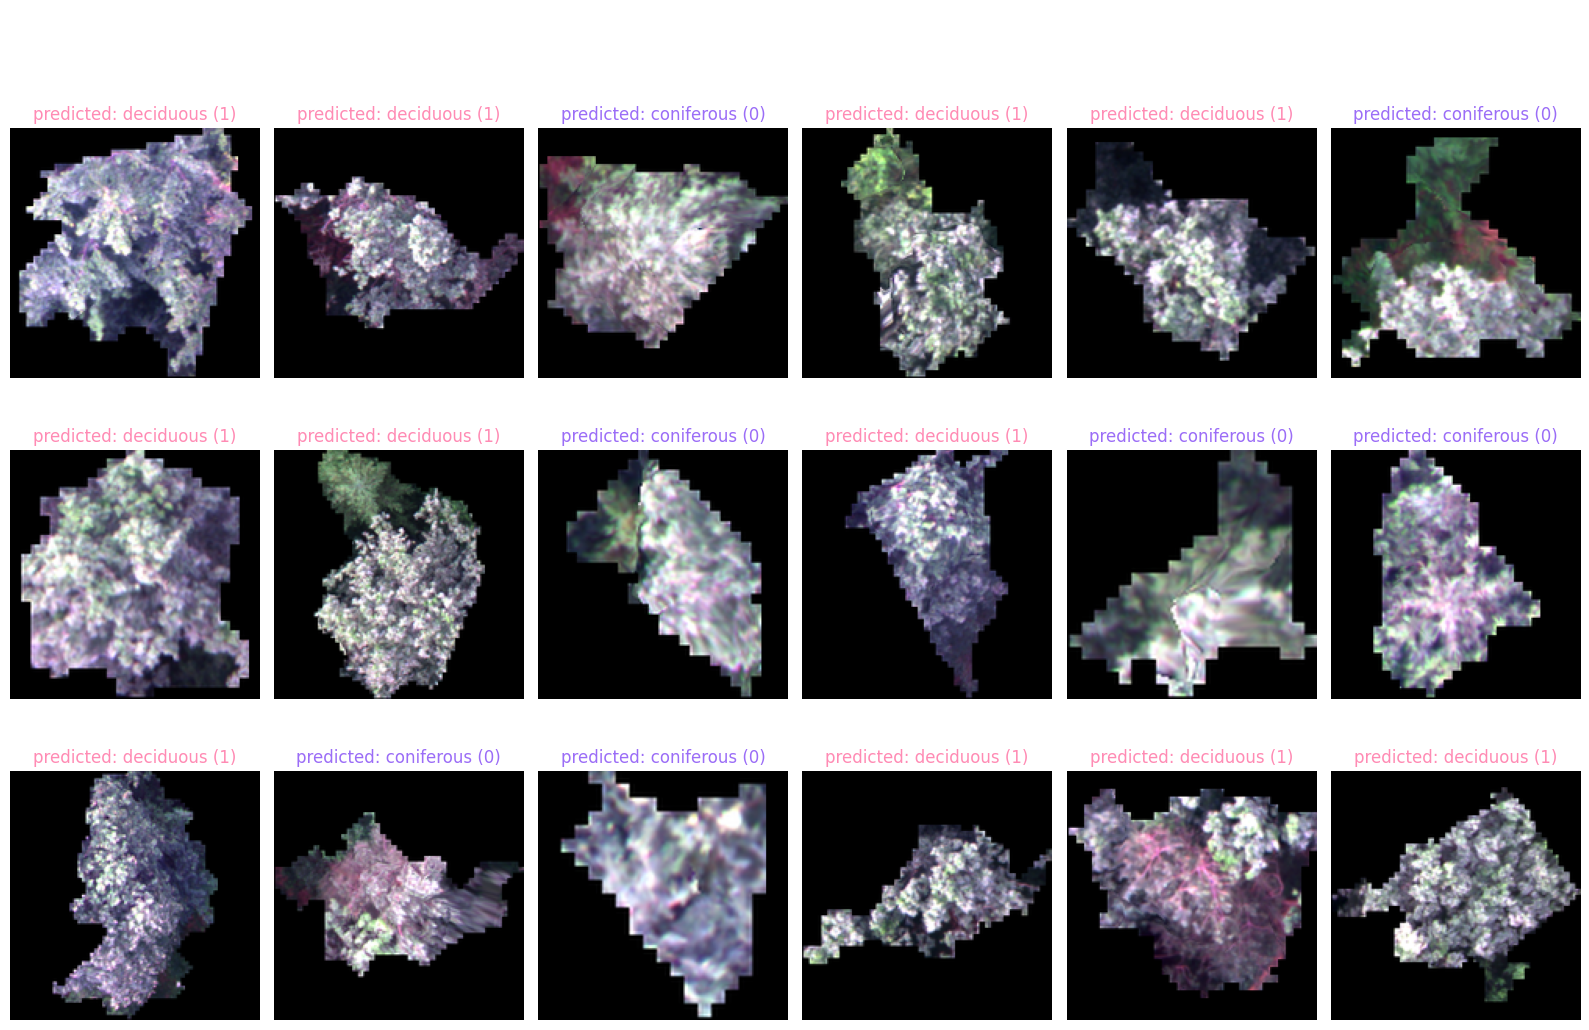

In [244]:
import matplotlib.pyplot as plt
import rasterio
from rasterio.mask import mask

# Number of samples to show
num_samples = 32
# Random shuffle
sample_indices = gdf_unlabeled.sample(n=18, random_state=42).index

# Prep figure with transparent background
plt.figure(figsize=(16, 11), facecolor='none')

with rasterio.open("orthophoto.tif") as src:
    for i, idx in enumerate(sample_indices):
        row = gdf_unlabeled.loc[idx]
        pred_label = row.get("predicted_type")

        if pred_label is None:
            continue

        if pred_label == 1:
            label_name = "deciduous (1)"
            title_color = "#ff8bb4"
        else:
            label_name = "coniferous (0)"
            title_color = "#9b6df7"

        try:
            out_image, _ = mask(src, [row.geometry], crop=True)
        except ValueError:
            continue

        img_array = out_image.transpose(1, 2, 0)
        if img_array.shape[2] < 3:
            continue

        rgb_array = img_array[:, :, :3]
        display_img = prepare_image(rgb_array)

        # Plot
        ax = plt.subplot(3, 6, i + 1)
        ax.imshow(display_img.astype("uint8"))
        ax.set_title(f"predicted: {label_name}", fontsize=12, color=title_color)
        ax.axis("off")
        ax.set_facecolor('none')

# Transparent main title
plt.suptitle("Model Predictions on Unlabeled Crowns", fontsize=18, fontweight='bold', color='white')

plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


### combine plabeled and predicted intp one data frame

In [245]:
# Make copies
gdf_labeled = gdf_labeled.copy()
gdf_unlabeled = gdf_unlabeled.copy()

# Add source labels
gdf_labeled["label_source"] = "labeled"
gdf_unlabeled["label_source"] = "predicted"

# Unify label column name before combining
gdf_labeled["type"] = gdf_labeled["type"]  # keep as is
gdf_unlabeled["type"] = gdf_unlabeled["predicted_type"]  # rename for merge

# Drop the old predicted_type column if it exists
gdf_unlabeled = gdf_unlabeled.drop(columns=["predicted_type"], errors="ignore")

# Combine both labeled and predicted
combined_gdf = gpd.GeoDataFrame(pd.concat([gdf_labeled, gdf_unlabeled], ignore_index=True))

combined_gdf

treeID  type                                           geometry  \
0        19   1.0  POLYGON ((344940.626 5756980.521, 344940.969 5...   
1        22   1.0  POLYGON ((344934.971 5756978.121, 344935.485 5...   
2        26   1.0  POLYGON ((344947.481 5756979.321, 344948.167 5...   
3        30   1.0  POLYGON ((344950.737 5756975.722, 344950.909 5...   
4        32   0.0  POLYGON ((344928.287 5756974.351, 344928.63 57...   
..      ...   ...                                                ...   
582     784   1.0  POLYGON ((344928.973 5756831.77, 344929.487 57...   
583     788   1.0  POLYGON ((344947.31 5756828.685, 344947.481 57...   
584     789   1.0  POLYGON ((344937.027 5756828, 344937.37 575682...   
585     790   1.0  POLYGON ((344943.025 5756829.371, 344943.368 5...   
586     797   1.0  POLYGON ((344946.796 5756825.429, 344947.31 57...   

    label_source  
0        labeled  
1        labeled  
2        labeled  
3        labeled  
4        labeled  
..           ...  
582    predicted  
583    predicted  
584    predicted  
585    predicted  
586    predicted  

[587 rows x 4 columns]